Compare run with OPS file to run with HRDPS file

In [1]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
tmask = mesh['tmask']

deptht = mesh['gdept_1d'][0]

In [11]:
year = '2023'
olddir = 'nowcast-green.201905/16feb23/'
newdir = '/data/dlatorne/16feb23/'

In [36]:
def surface_plots(tracers, file, month, cmap, cdiff, vmax, vmin, dvmax, it=0, twoD=False, olddir=olddir, 
                  d201905=False, zoom=[0, 0, 0, 0], dl=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 7))

    dm = xr.open_dataset(
            f'/results2/SalishSea/{olddir}/SalishSea_1h_{year}{month}_{year}{month}_{file}_T.nc')

    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    if twoD:
        mean_field = np.ma.array(dm[tracer][it], mask=1-tmask[0, 0])
    else:
        mean_field = np.ma.array(dm[tracer][it, dl], mask=1-tmask[0, dl])
    colours = axs[0].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0].set_title(olddir)
    fig.colorbar(colours, ax=axs[0])
    
    ds = xr.open_dataset(
        f'/{newdir}/SalishSea_1h_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]
    
    if twoD:
        field = np.ma.array(ds[tracer][it], mask=1-tmask[0,0])
    else:
        field = np.ma.array(ds[tracer][it, dl], mask=1-tmask[0, dl])
    colours = axs[1].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[1].set_title("HRDPS")
    fig.colorbar(colours, ax=axs[1])
    
    colours = axs[2].pcolormesh(field-mean_field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
    axs[2].set_title("New - Old")
    fig.colorbar(colours, ax=axs[2])
    ds.close()
    dm.close()

    for ax in axs:
        viz_tools.set_aspect(ax)
        if sum(zoom) > 0:
            ax.set_ylim(zoom[0], zoom[1])
            ax.set_xlim(zoom[2], zoom[3])
            
            
    return fig

In [41]:
def profiles(tracers, file, olddir=olddir, d201905=False, dosum=False, it=0):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    
    dm = xr.open_dataset(
            f'/results2/SalishSea/{olddir}/SalishSea_1h_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    
    mean_field = np.ma.array(dm[tracer][it], mask=1-tmask[0])
    axs[0].plot(mean_field.mean(axis=1).mean(axis=1), deptht, linewidth=2, label='Old')
    axs[1].plot(np.zeros_like(deptht), deptht, linewidth=2, label='Old')
    
    ds = xr.open_dataset(
        f'/{newdir}/SalishSea_1h_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.ma.array(ds[tracer][it], mask=1-tmask[0])
    axs[0].plot(field.mean(axis=1).mean(axis=1), deptht, label='New')
    
    axs[1].plot((field-mean_field).mean(axis=1).mean(axis=1), deptht, label='New')
    print (mean_field.mean(axis=1).mean(axis=1).max(), field.mean(axis=1).mean(axis=1).max())
    ds.close()
    dm.close()

    
    axs[0].invert_yaxis()
    axs[0].legend(loc='best')
    
    axs[1].invert_yaxis()
    axs[1].legend(loc='best')
    
    return fig

In [57]:
def thalweg_plots(tracers, file, cmap, cdiff, vmax, vmin, dvmax, olddir=olddir, it=0, d201905=False, maxdepth=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    dm = xr.open_dataset(
            f'/results2/SalishSea/{olddir}/SalishSea_1h_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
        
    mean_field = np.array(dm[tracer][it])
    colours = vis.contour_thalweg(axs[0], mean_field, bathy, mesh, np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)
    axs[0].set_title(olddir)

    ds = xr.open_dataset(
        f'/{newdir}/SalishSea_1h_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.array(ds[tracer][it])
    colours = vis.contour_thalweg(axs[1], field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)

    axs[1].set_title(newdir)
    colours = vis.contour_thalweg(axs[2], field-mean_field, bathy, mesh, np.arange(-dvmax, 1.2*dvmax, dvmax/5), 
                                      cmap=cdiff)
 
    axs[2].set_title('New - Old')
    if maxdepth > 0:
        for ax in axs:
            ax.set_ylim(maxdepth, 0)
    ds.close()
    dm.close()

    fig.tight_layout()
    return fig

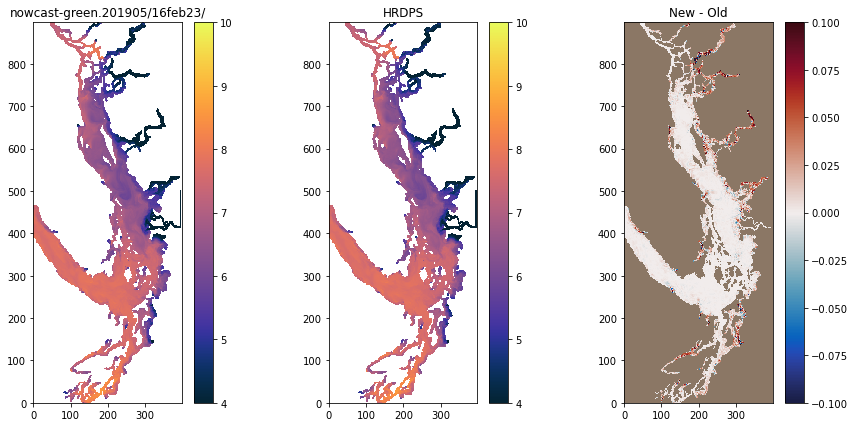

In [72]:
tracer = 'votemper'
file = 'grid'
month = '0216'
cmap = cm.thermal
cdiff = cm.balance
vmax = 10
vmin = 4
dvmax = 0.1
it = 23
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=it)

9.22827166310137 9.228266269515919


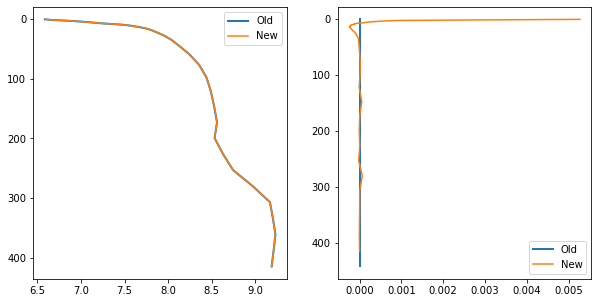

In [73]:
fig = profiles(tracer, file, it=it)

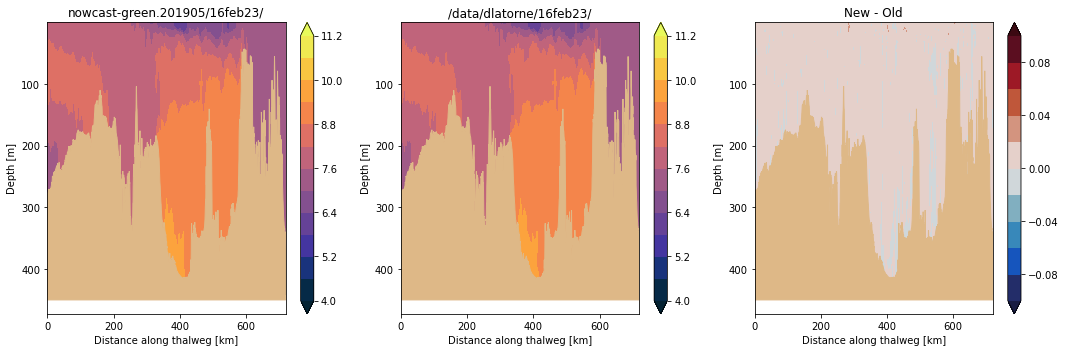

In [74]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=it)

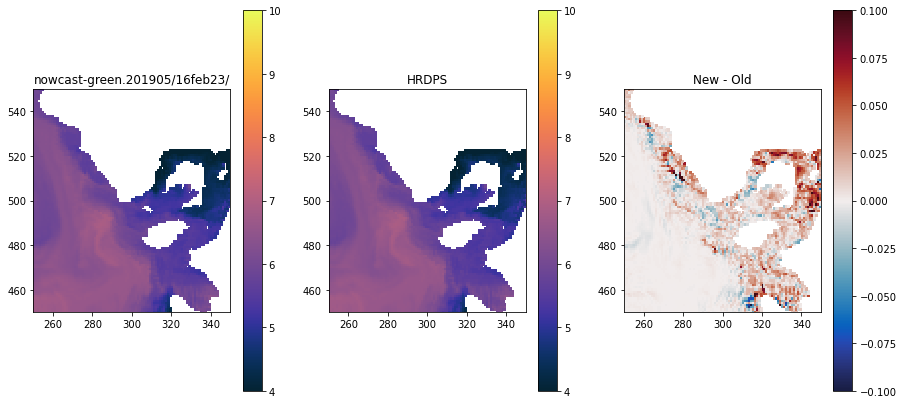

In [21]:
zoom = [450, 550, 250, 350]
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it, zoom=zoom)

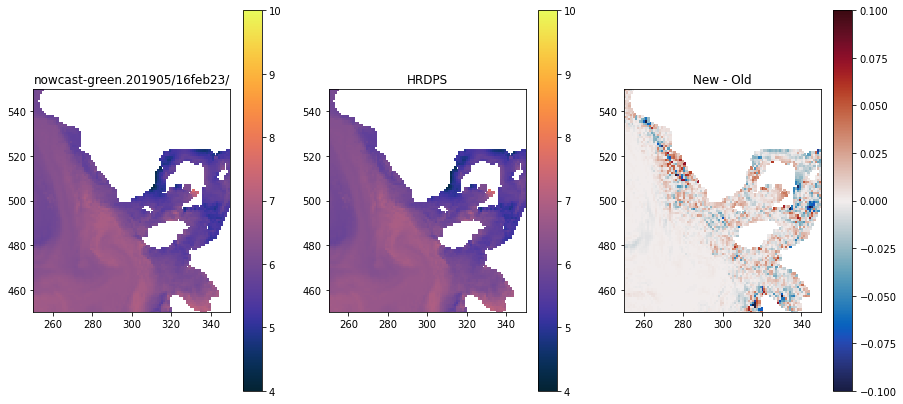

In [25]:
zoom = [450, 550, 250, 350]
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it, zoom=zoom, dl=2)

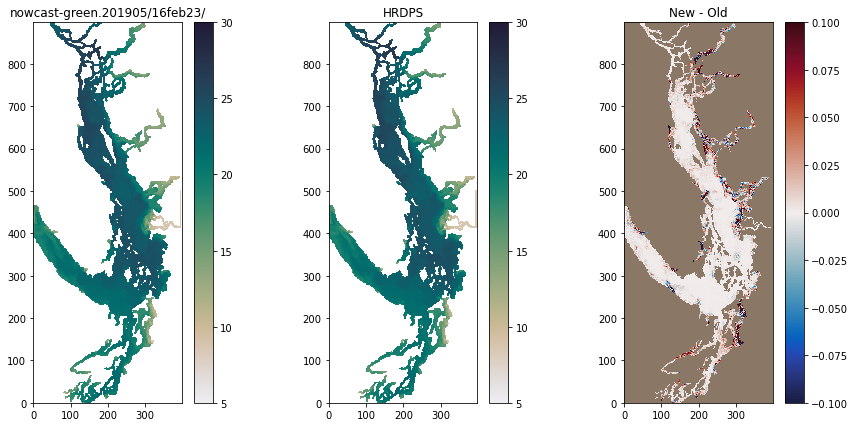

In [60]:
tracer = 'nitrate'
file = 'ptrc'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 5
dvmax = 0.1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=it)

29.862195414860288 29.862244006368964


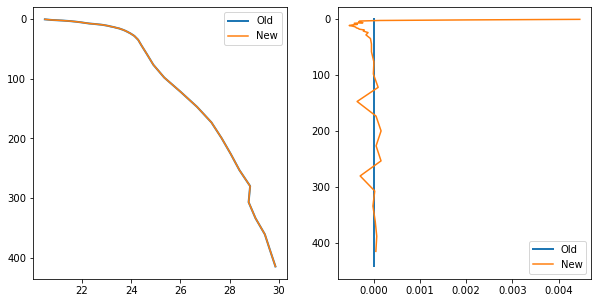

In [61]:
fig = profiles(tracer, file, it=it)

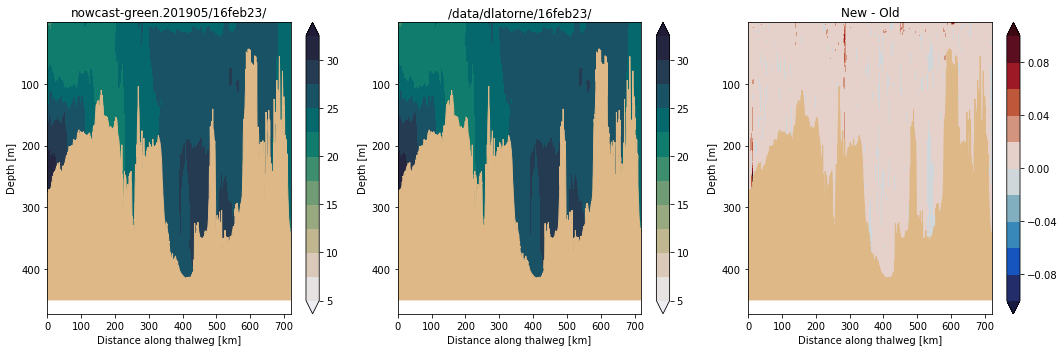

In [62]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=it)

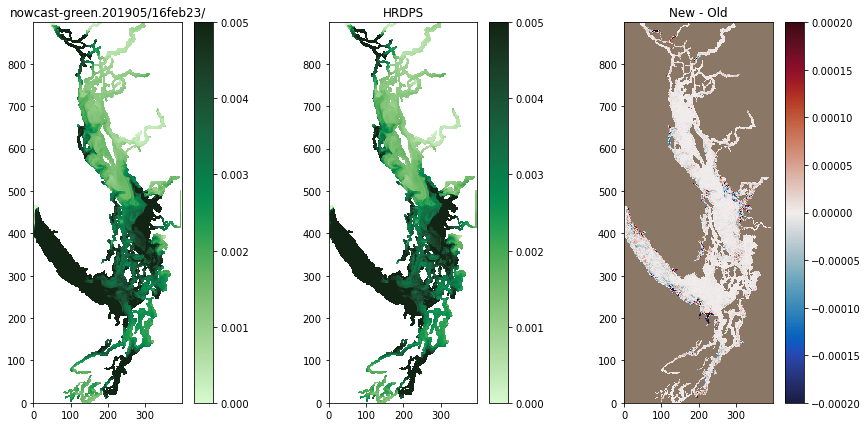

In [63]:
tracer = 'diatoms'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 0.005
vmin = 0
dvmax = 0.0002
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=it)

0.005326772253021467 0.005328549238101597


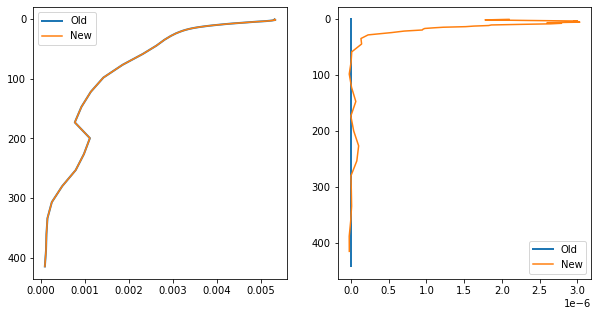

In [64]:
fig = profiles(tracer, file, it=it)

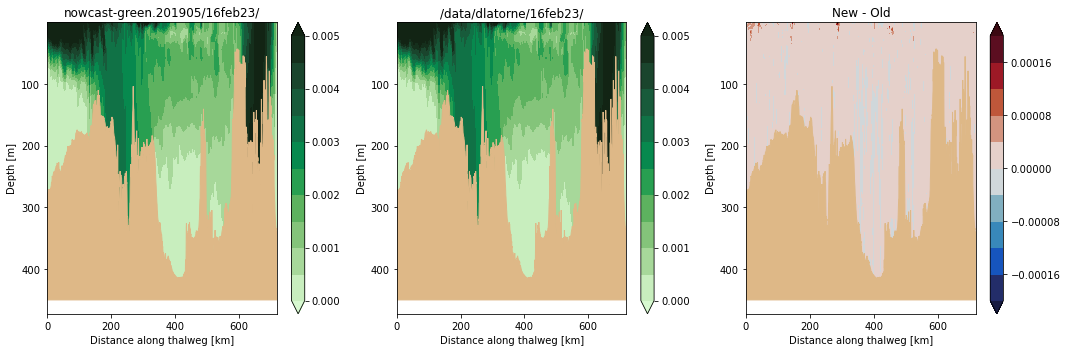

In [65]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=it)

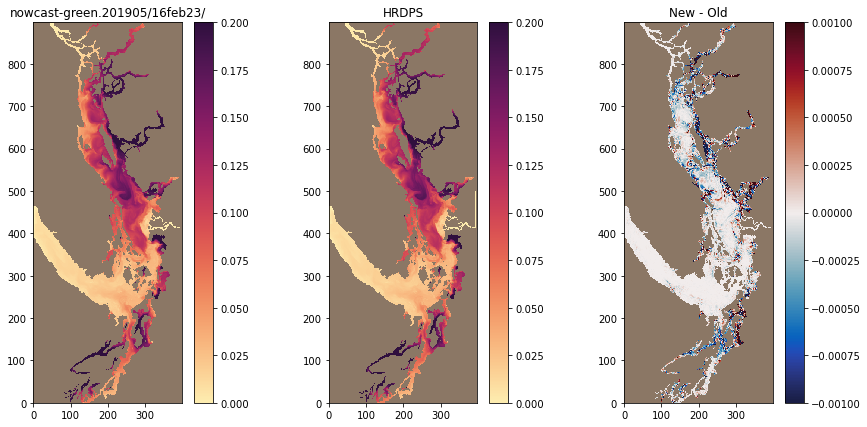

In [66]:
tracer = 'microzooplankton'
file = 'ptrc'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Microzooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Microzooplankton (uM N)'
vmax = 0.2
vmin = 0
dvmax = 0.001
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=it)

0.07351020135290928 0.07347269931041671


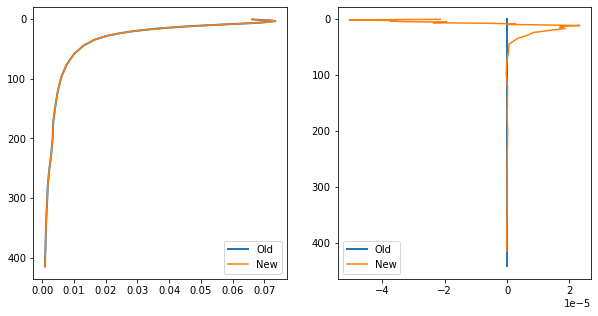

In [67]:
fig = profiles(tracer, file, it=it)

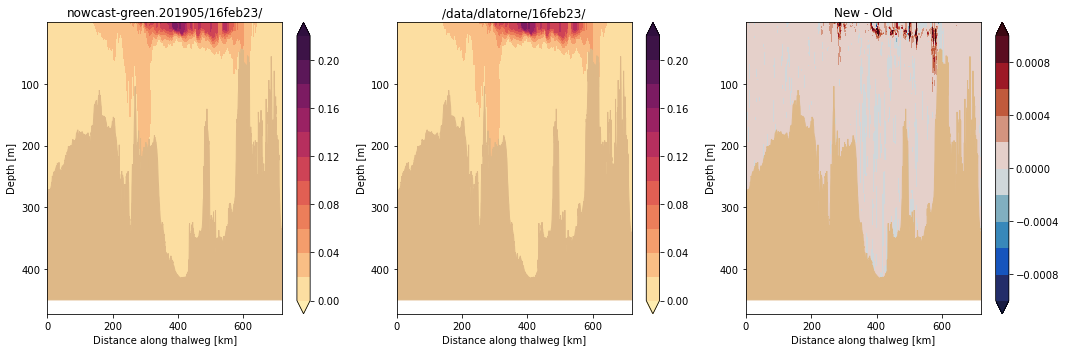

In [68]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=it)

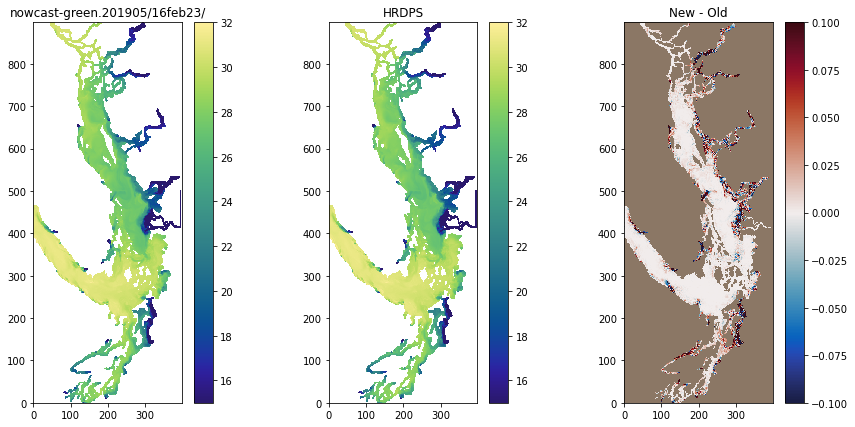

In [69]:
tracer = 'vosaline'
file = 'grid'
cmap = cm.haline
cdiff = cm.balance
vmax = 32
vmin = 15
dvmax = 0.1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23)

31.61225679910404 31.612257694342805


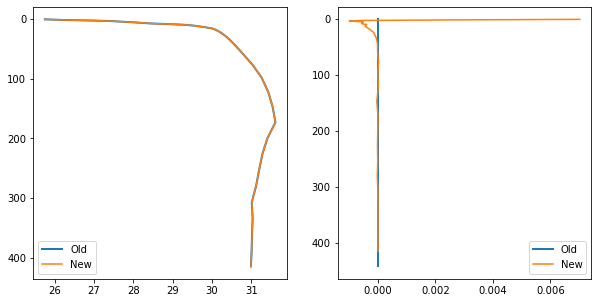

In [70]:
fig = profiles(tracer, file, it=it)

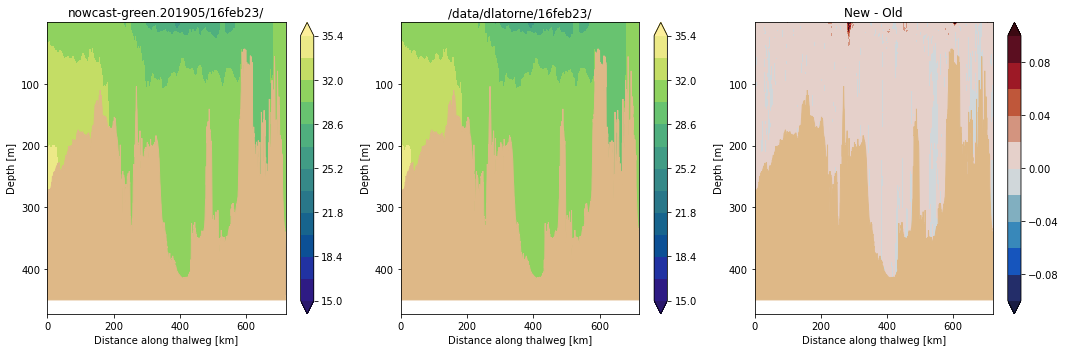

In [71]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=it)

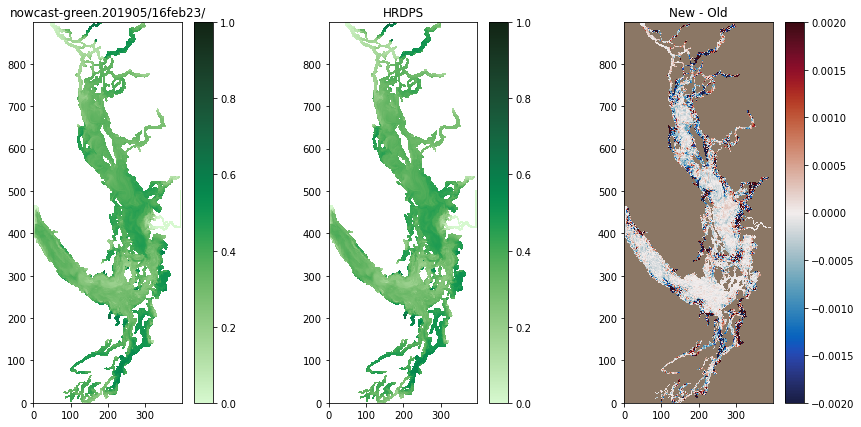

In [78]:
tracer = 'flagellates'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.002
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=it)

0.32372471339314396 0.323691792131684


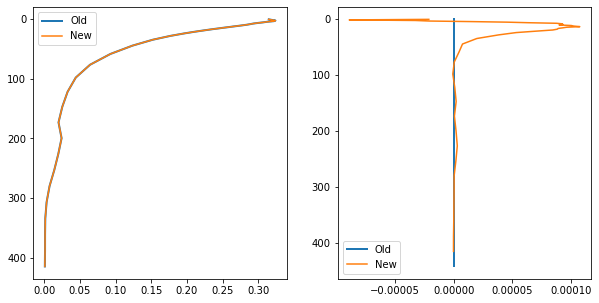

In [79]:
fig = profiles(tracer, file, it=it)

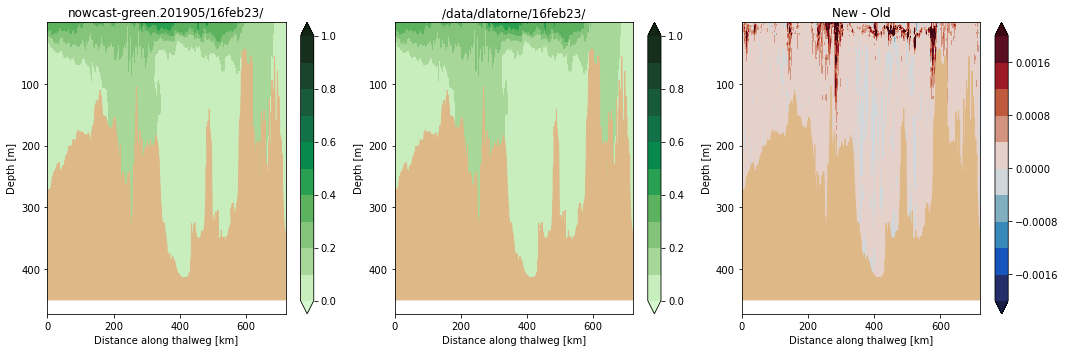

In [80]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=it)

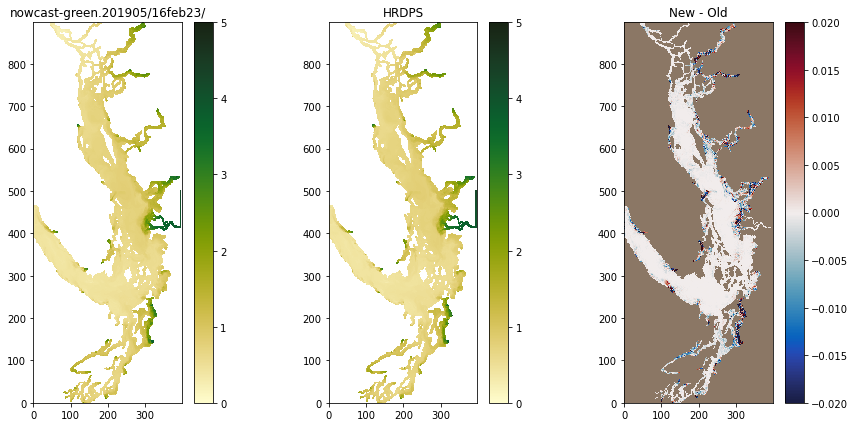

In [83]:
tracer = 'ammonium'
file = 'ptrc'
cmap = cm.speed
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 0.02
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=it)

0.9685902246845062 0.9678506214022128


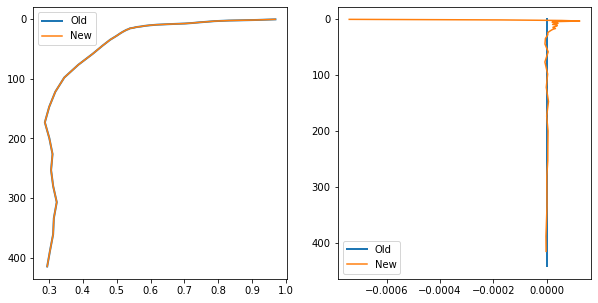

In [84]:
fig = profiles(tracer, file, it=it)

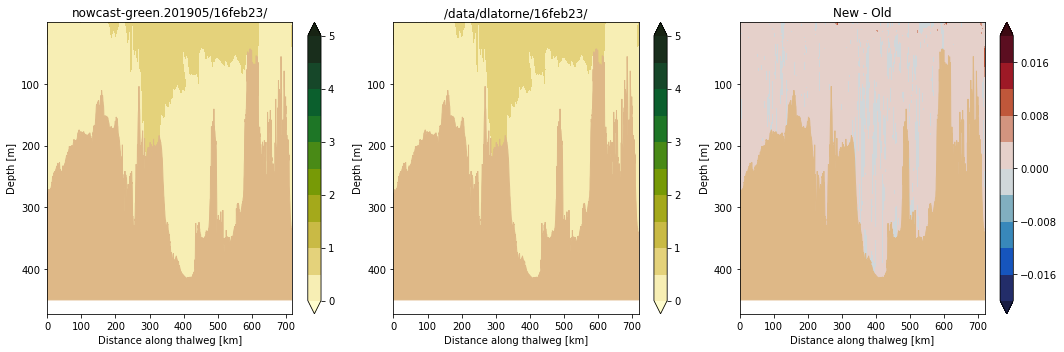

In [85]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=it)

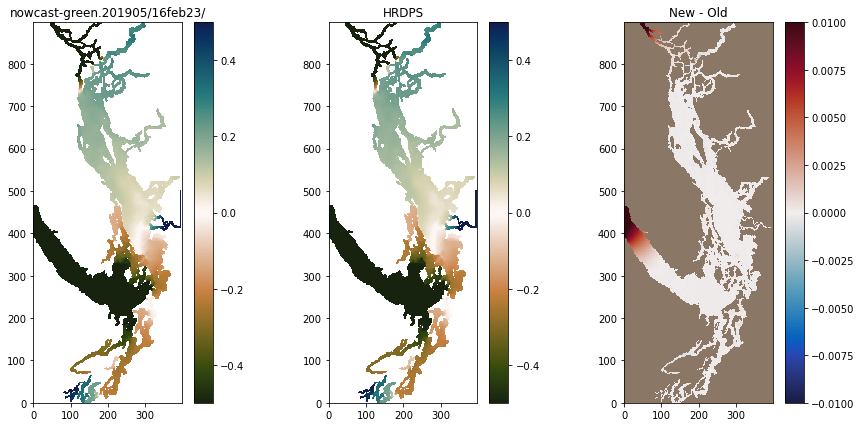

In [92]:
tracer = 'sossheig'
file = 'grid'
cmap = cm.tarn
cdiff = cm.balance
vmax = 0.5
vmin = -0.5
dvmax = 0.01
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, twoD=True, it=it)

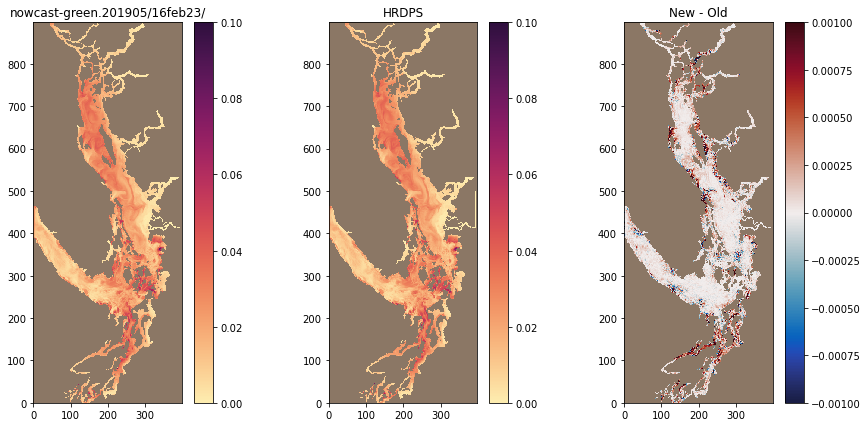

In [95]:
tracer = 'particulate_organic_nitrogen'
file = 'ptrc'
cmap = cm.matter
cdiff = cm.balance
vmax = 0.1
vmin = 0
dvmax = 0.001
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=it)

0.040943869728332465 0.04093694116312328


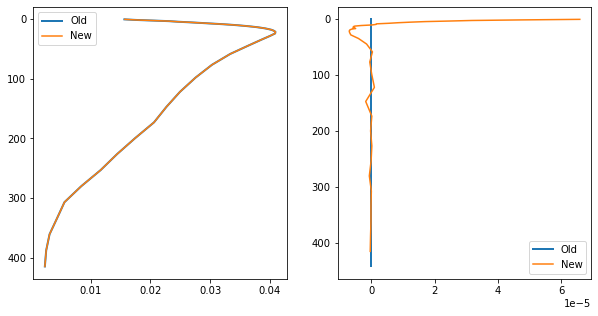

In [96]:
fig = profiles(tracer, file, it=it)

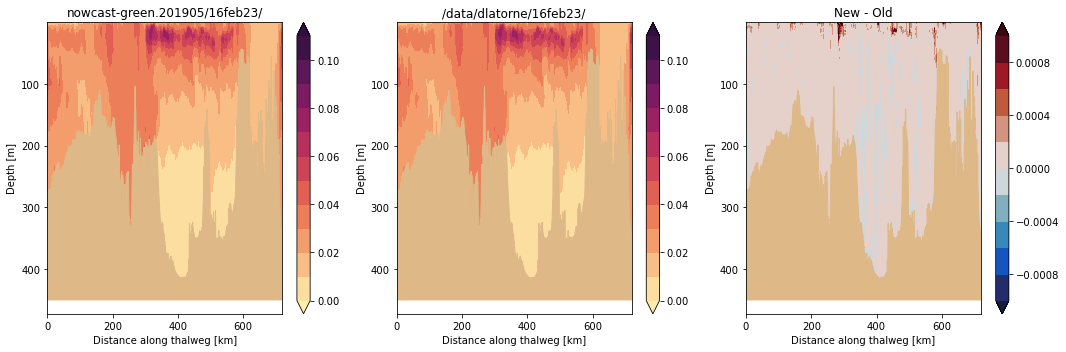

In [97]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=it)

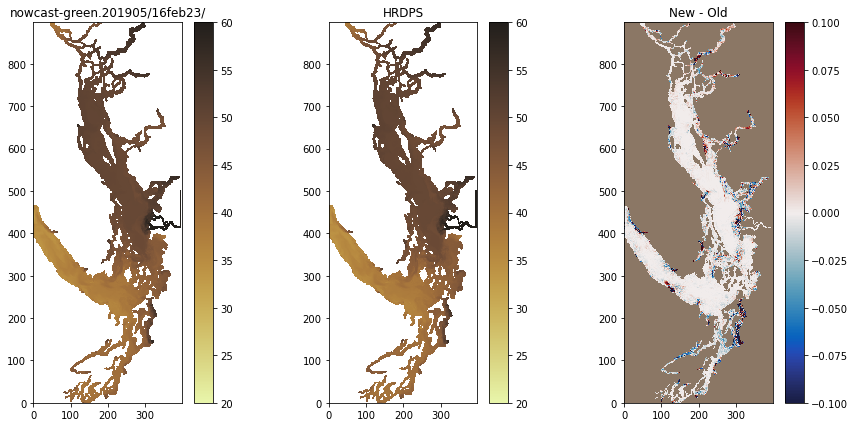

In [100]:
tracer = 'silicon'
file = 'ptrc'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 20
dvmax = 0.1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=it)

82.57588049457462 82.57610201524788


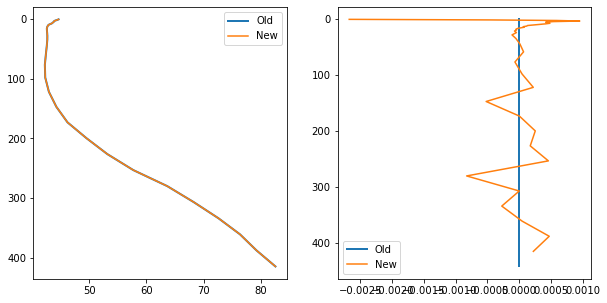

In [101]:
fig = profiles(tracer, file, it=it)

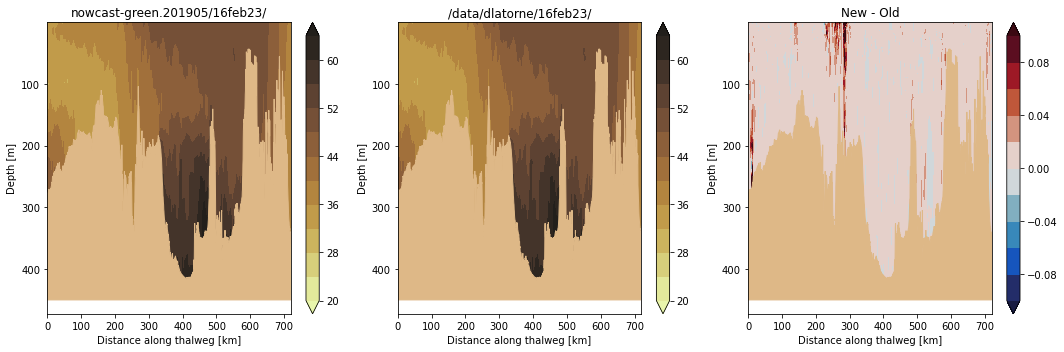

In [102]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=it)

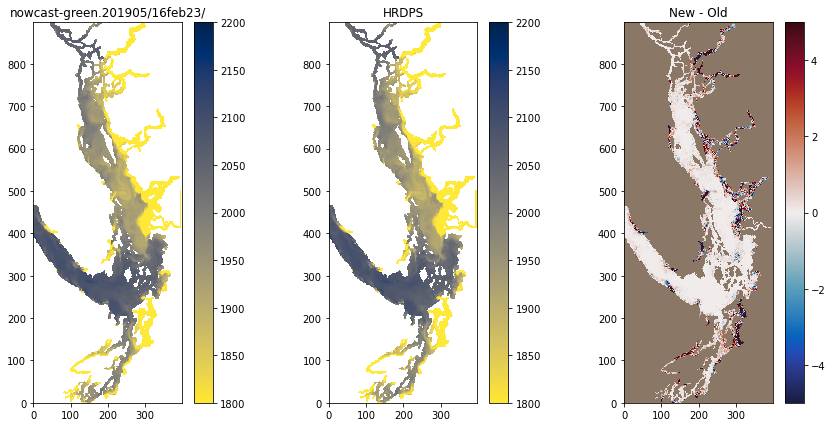

In [105]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2200
vmin = 1800
dvmax = 5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=it)

2157.0917258814293 2157.092132705162


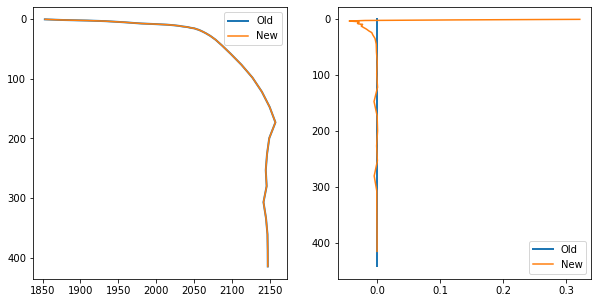

In [106]:
fig = profiles(tracer, file, it=it)

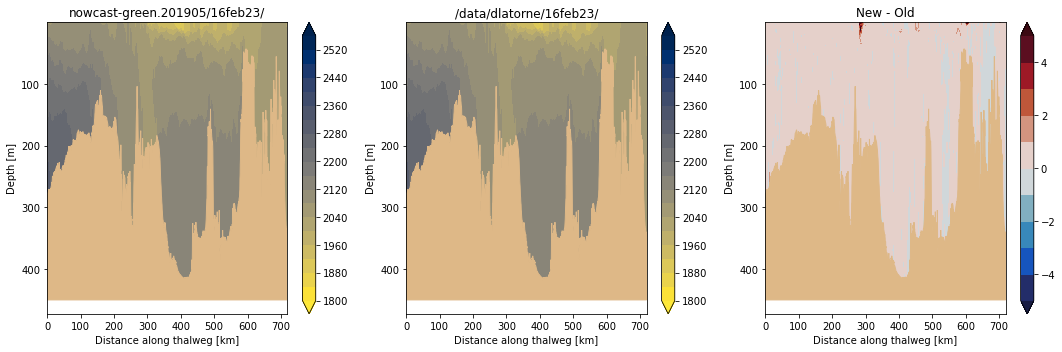

In [107]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=it)

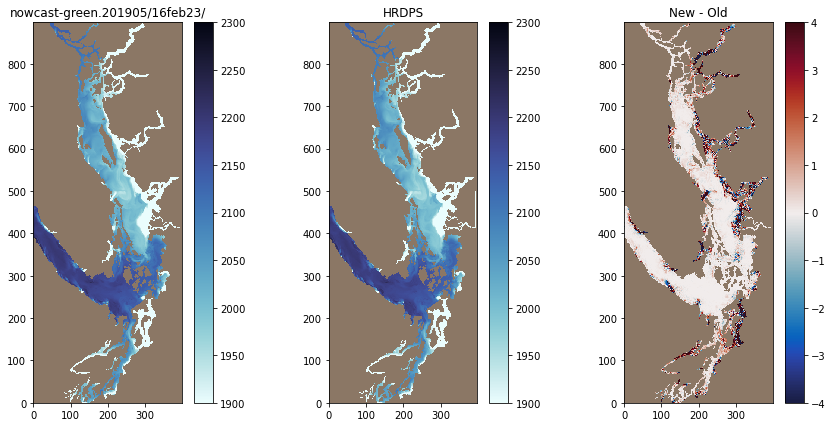

In [109]:
tracer = 'total_alkalinity'
file = 'carp'
cmap = cm.ice_r
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 2300
vmin = 1900
dvmax = 4
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=it)

2209.9122365997086 2209.9122875822645


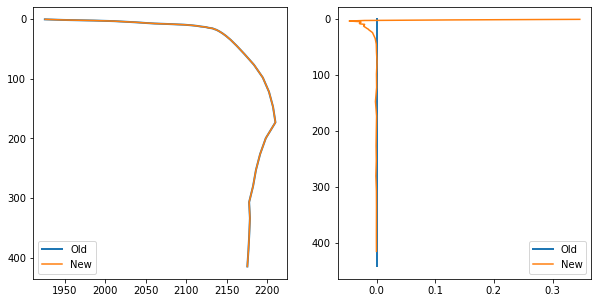

In [110]:
fig = profiles(tracer, file, it=it)

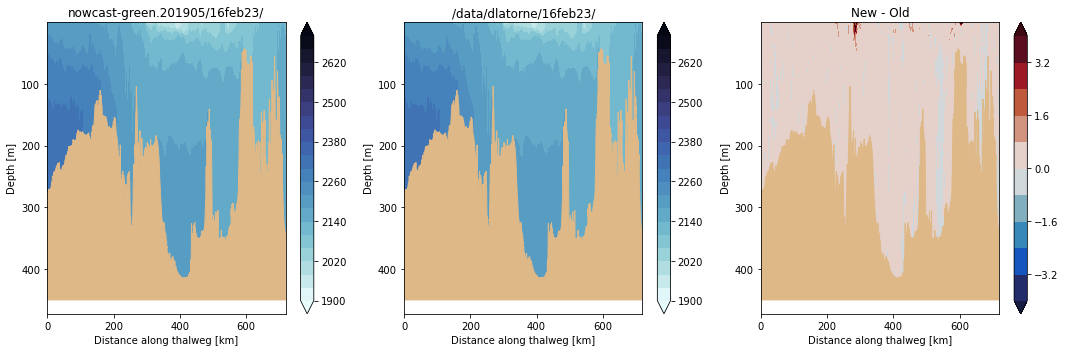

In [111]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=it)

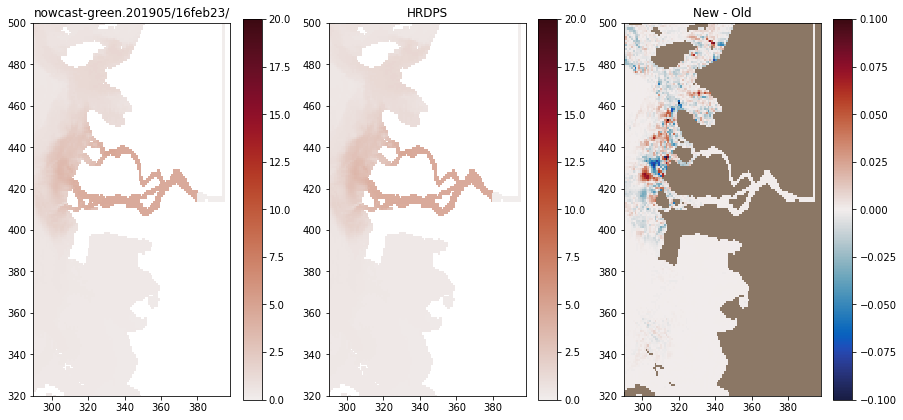

In [114]:
tracer = 'Fraser_tracer'
file = 'carp'
cmap = cm.amp
cdiff = cm.balance
vmax = 20
vmin = 0
dvmax = 0.1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax,
                    zoom=[320, 500, 290, 398], it=it)

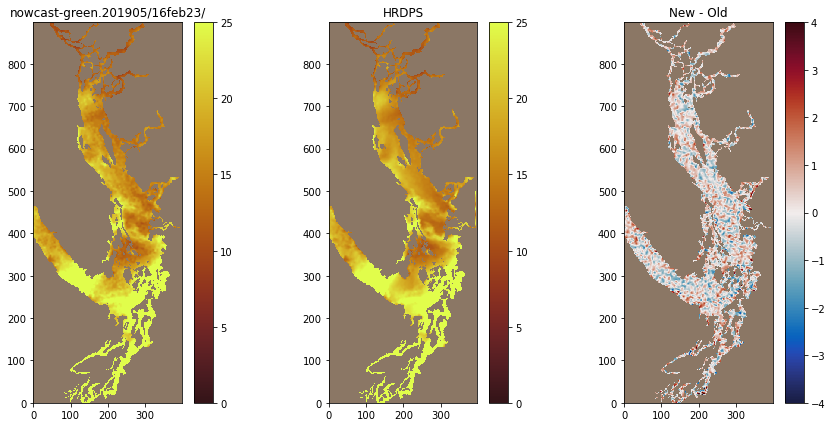

In [116]:
tracer = 'PAR'
file = 'carp'
cmap = cm.solar
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 25
vmin = 0
dvmax = 4
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=it)

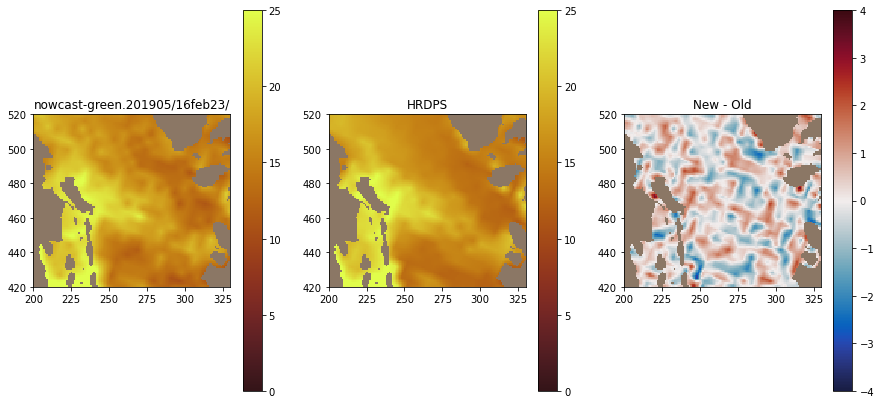

In [118]:
tracer = 'PAR'
file = 'carp'
cmap = cm.solar
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 25
vmin = 0
dvmax = 4
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=it, zoom=[420, 520, 200, 330])

22.670382068881654 22.785195488693144


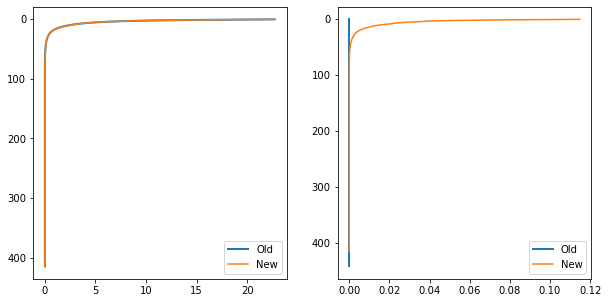

In [119]:
fig = profiles(tracer, file, it=it)